In [1]:
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import visualize
import geometry_utils
import dataloader_paths, dataloader_geo

from maritime_traffic_network import MaritimeTrafficNetwork
from dijkstra_path_prediction import DijkstraPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_dates = ['202205']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, data_version='')

In [4]:
# train model
model = DijkstraPathPrediction()
model.train(network.G_pruned, training_paths)

In [5]:
# Load test data from file
selection_start = 0
selection_end = -1
selection_step = 2
traj_path_prefix = '../../data/processed/'
test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                  selection_start, selection_end, selection_step, data_version='')
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [6]:
# MAKE PREDICTIONS
n_start_nodes = 1
predictions = model.predict(test_paths, n_start_nodes=n_start_nodes, weight='inverse_weight')

Making predictions for 724 samples
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Evaluating 724 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.43 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 266.27m
Median SSPD: 141.86m
Mean choice_accuracy: 0.5468


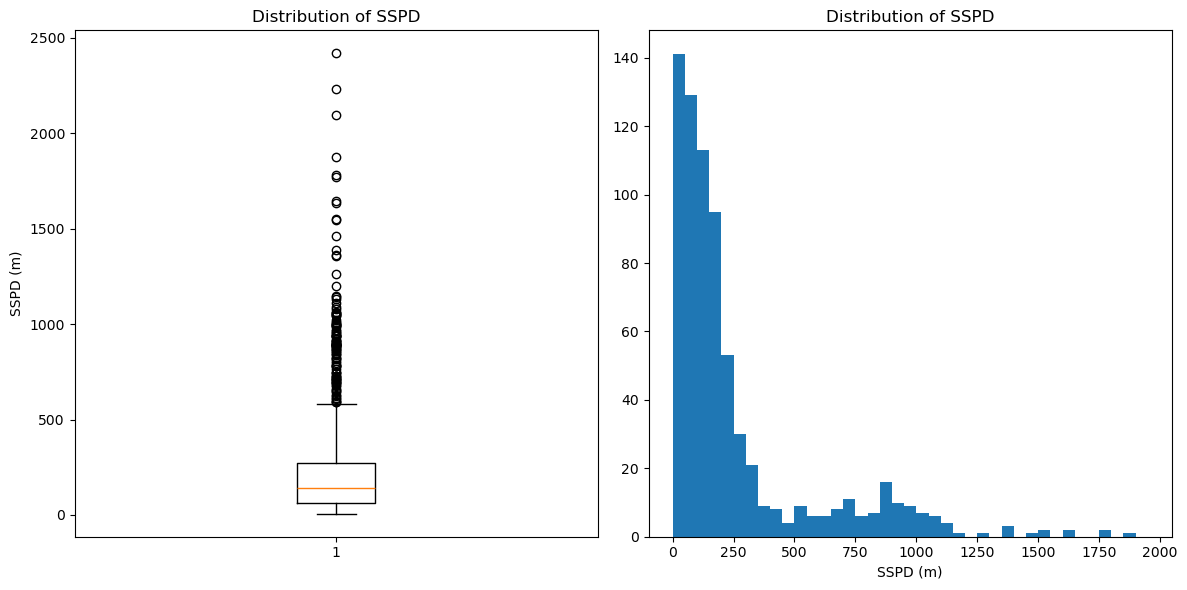

In [7]:
# evaluate
eval_mode = 'trajectory'
evaluation_results, fig = metrics.evaluate_given_predictions('path', predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, eval_mode=eval_mode)

In [8]:
# make predictions with the Dijkstra model and plot
i = 0
example = test_paths.iloc[i]
mmsi = example.mmsi
start_node = [example.path[0], example.path[1]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

predictions, flag = model.predict_path(start_node[-1], end_node)
predictions = start_node[:-1] + predictions
predictions = {tuple(predictions):1}

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_dijkstra_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_dijkstra_predictions.html"}')

Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM_dijkstra_predictions.html
